# Introduction

### This notebook focuses on detecting anomalies in financial markets using the XGBoost model and implementing an investment strategy based on the detected anomalies. The strategy uses key market indicators, such as price and moving averages, to generate buy, sell, or hold recommendations. Additionally, a chatbot is integrated to provide real-time insights and respond to user queries about the current strategy, anomalies, and market conditions.

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from flask import Flask, request, jsonify
import threading
from threading import Thread
import requests
import yfinance as yf
import re
import logging

# Data Cleaning

In [81]:
dataset = pd.read_excel('../data/FinancialMarketData.xlsx', sheet_name='EWS')

# Select only the crucial columns
selected_columns = ['Y' ,'DXY', 'VIX', 'BDIY', 'CRY', 'Data']
dataset = dataset[selected_columns]

# Calculate moving averages
dataset['VIX_moving_average'] = dataset['VIX'].rolling(window=7).mean()
dataset['BDIY_moving_average'] = dataset['BDIY'].rolling(window=7).mean()
dataset['CRY_moving_average'] = dataset['CRY'].rolling(window=7).mean()
dataset['DXY_moving_average'] = dataset['DXY'].rolling(window=7).mean()

# Calculate ratio
dataset['DXY_to_VIX'] = dataset['DXY'] / dataset['VIX']

# Convert 'Data' column to datetime and set it as the index
dataset['Data'] = pd.to_datetime(dataset['Data'])  # Ensure the 'Data' column is in datetime format
dataset.set_index('Data', inplace=True)  # Set 'Data' as the index

# Handle missing values (if any)
dataset_cleaned = dataset.ffill().bfill()


print( dataset_cleaned.columns)

dataset_cleaned.describe()


Index(['Y', 'DXY', 'VIX', 'BDIY', 'CRY', 'VIX_moving_average',
       'BDIY_moving_average', 'CRY_moving_average', 'DXY_moving_average',
       'DXY_to_VIX'],
      dtype='object')


,Y,DXY,VIX,BDIY,CRY,VIX_moving_average,BDIY_moving_average,CRY_moving_average,DXY_moving_average,DXY_to_VIX
count,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000,1111.000000
mean,0.213321,90.934982,19.992169,2259.860486,245.247649,20.005920,2257.610904,245.190931,90.967069,5.192057
std,0.409837,11.379095,8.642157,2017.811888,68.278081,8.115228,1996.043251,67.991467,11.349187,1.780666
min,0.000000,71.329000,9.430000,291.000000,106.292900,10.151429,322.857143,119.503429,72.127000,1.291721
25%,0.000000,81.240500,13.640000,990.000000,184.705650,14.124286,1001.142857,184.704664,81.531929,3.808384
50%,0.000000,89.716000,17.980000,1518.000000,234.560000,17.757143,1512.285714,232.279100,89.828429,5.082427
75%,0.000000,97.404000,23.625000,2685.500000,301.539250,23.593571,2698.214286,302.611400,97.351929,6.438958
max,1.000000,119.820000,75.910000,11793.000000,467.570000,60.937143,10799.428571,446.368571,118.951429,10.005823


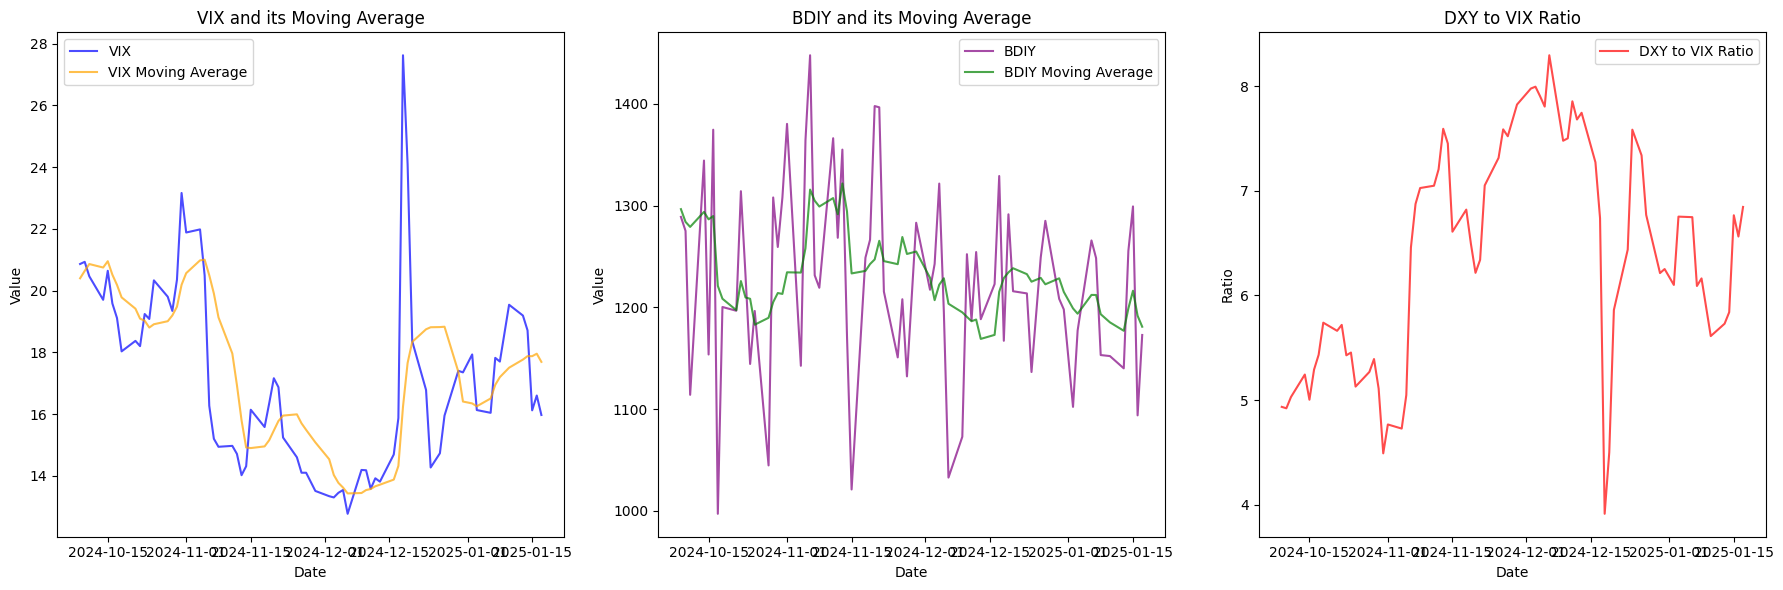

In [92]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plot VIX and its Moving Average
axes[0].plot(dataset['VIX'], label='VIX', alpha=0.7, color='blue')
axes[0].plot(dataset['VIX_moving_average'], label='VIX Moving Average', alpha=0.7, color='orange')
axes[0].set_title("VIX and its Moving Average")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Value")
axes[0].legend()

# Plot BDIY and its Moving Average
axes[1].plot(dataset['BDIY'], label='BDIY', alpha=0.7, color='purple')
axes[1].plot(dataset['BDIY_moving_average'], label='BDIY Moving Average', alpha=0.7, color='green')
axes[1].set_title("BDIY and its Moving Average")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Value")
axes[1].legend()

# Plot DXY to VIX Ratio
axes[2].plot(dataset['DXY_to_VIX'], label='DXY to VIX Ratio', alpha=0.7, color='red')
axes[2].set_title("DXY to VIX Ratio")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Ratio")
axes[2].legend()


plt.tight_layout()

plt.show()


# Data Preperation For Training

In [83]:
X= dataset_cleaned.drop(columns=['Y'])
y=dataset_cleaned['Y']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Model Training

## Training the XGBoost Classifier

In [84]:
# Model inisialization
model = XGBClassifier(
    n_estimators=130, 
    learning_rate=0.3, 
    random_state=43, 
    scale_pos_weight=5
)

model.fit(X_train, y_train)

#  prediction model
y_pred = model.predict(X_test)

print("Classification Report :")
print(classification_report(y_test, y_pred))


Classification Report :
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       177
           1       0.75      0.72      0.73        46

    accuracy                           0.89       223
   macro avg       0.84      0.83      0.83       223
weighted avg       0.89      0.89      0.89       223



# Investment Strategy Implementation

### In this section, we will define and implement a data-driven investment strategy based on the model's predictions.


In [93]:
def fetch_real_time_data(tickers, window=5, ticker_exceptions={}):
    """
    Downloads real-time data for the given tickers, renames critical tickers, 
    simulates data for non-critical and missing tickers, and calculates moving averages 
    and the DXY_to_VIX ratio.

    Parameters:
        - tickers: List of tickers to download data for.
        - window: Size of the rolling window for calculating moving averages.
        - ticker_exceptions:  A dictionary specifying custom mappings for certain tickers.

    Returns:
        - final_data: DataFrame containing downloaded and simulated data with derived features.
    """
    final_data = pd.DataFrame()
    fetched_tickers = []
    missing_tickers = []
    simulated_names = {}
    inv_count = 0  # Counter for simulated tickers

    # List of critical tickers
    critical_tickers = ['DX-Y.NYB', '^VIX']
    # Tickers to simulate
    simulated_tickers = ['BDIY', 'CRY']

    # Download data for the given tickers
    for ticker in tickers:
        try:
            # Download historical data
            data = yf.download(ticker, start="2024-10-01", interval="1d", progress=False)
            if data.empty:
                print(f"No data available for the ticker: {ticker}")
                missing_tickers.append(ticker)
                continue

            # Map critical tickers
            if ticker in critical_tickers:
                mapped_name = ticker_exceptions.get(ticker, ticker)
            else:
                # Automatically map other tickers
                mapped_name = ticker_exceptions.get(ticker, re.sub(r'\W+', '', ticker)[:3].upper())

            final_data[mapped_name] = data['Close']
            fetched_tickers.append(ticker)
            print(f"Data downloaded for ticker: {ticker} (mapped to '{mapped_name}')")
        except Exception as e:
            print(f"Error downloading data for ticker {ticker}: {e}")
            missing_tickers.append(ticker)

    # Define a default time index if no tickers were downloaded
    if not final_data.empty:
        index = final_data.index
    else:
        # Create a default time index if no data is available
        index = pd.date_range(start=pd.Timestamp.today() - pd.Timedelta(days=30), periods=window * 4, freq='D')
        final_data = pd.DataFrame(index=index)

    # Simulate data for non-critical tickers that were not downloaded
    for ticker in simulated_tickers:
        mapped_name = ticker_exceptions.get(ticker, ticker)
        if mapped_name not in final_data.columns:
            if ticker == 'BDIY':
                final_data[mapped_name] = np.random.normal(1200, 100, size=len(index))
                print("Simulated data for BDIY with increased variance.")
            elif ticker == 'CRY':
                final_data[mapped_name] = np.random.normal(300, 10, size=len(index))
                print("Simulated data for CRY with increased variance.")

    # Simulate data for missing tickers
    for ticker in missing_tickers:
        # Simulated name, e.g., 'INV', 'INV_1', etc.
        base_simulated_name = 'INV'
        if base_simulated_name not in final_data.columns and base_simulated_name not in simulated_names.values():
            simulated_name = base_simulated_name
        else:
            inv_count += 1
            simulated_name = f'{base_simulated_name}_{inv_count}'

        final_data[simulated_name] = np.random.normal(100, 20, size=len(index))
        simulated_names[ticker] = simulated_name
        print(f"Simulated data for missing ticker: {ticker} mapped to '{simulated_name}'")

    # Check if required columns are present
    required_columns = ['DXY', 'VIX']
    for col in required_columns:
        if col not in final_data.columns:
            print(f"Warning: Critical ticker {col} is missing and will not be simulated.")

    # Calculate moving averages and ratios if required columns exist
    if all(col in final_data.columns for col in required_columns):
        final_data['VIX_moving_average'] = final_data['VIX'].rolling(window=window).mean()
        final_data['BDIY_moving_average'] = final_data['BDIY'].rolling(window=window).mean()
        final_data['CRY_moving_average'] = final_data['CRY'].rolling(window=window).mean()
        final_data['DXY_moving_average'] = final_data['DXY'].rolling(window=window).mean()
        final_data['DXY_to_VIX'] = final_data['DXY'] / final_data['VIX']
        print("Moving averages and ratios calculated successfully.")
    else:
        print("Unable to calculate moving averages or ratios due to missing critical columns.")

    # Drop rows with missing values
    final_data = final_data.dropna()

    return final_data


In [86]:
def predict_anomaly(model, features):
    """
    Predicts the probability of an anomaly using the pre-trained model.
    Returns a Series containing the anomaly probabilities.

    Parameters:
        - model: The pre-trained model (must implement the `predict_proba` method).
        - features: A DataFrame containing the required columns for the model.

    Returns:
        - anomaly_probs: A Series containing the probability of an anomaly for each row.
    """
    # Define the required columns for the model to perform predictions
    required_columns = [
        'DXY', 'VIX', 'BDIY', 'CRY',  # Key indicators
        'VIX_moving_average',         # Moving average of VIX
        'BDIY_moving_average',        # Moving average of BDIY
        'CRY_moving_average',         # Moving average of CRY
        'DXY_moving_average',         # Moving average of DXY
        'DXY_to_VIX'                  # Ratio of DXY to VIX
    ]

    # Check if any required columns are missing in the features DataFrame
    missing_columns = [col for col in required_columns if col not in features.columns]
    if missing_columns:
        raise ValueError(f"The following required columns are missing: {missing_columns}")

    # Select only the required columns from the features DataFrame
    model_features = features[required_columns]

    # Check for any missing values in the selected features
    if model_features.isnull().values.any():
        raise ValueError("The selected features contain missing values. Please clean the data before making predictions.")

    # Predict anomaly probabilities using the model
    try:
        anomaly_probs = model.predict_proba(model_features)[:, 1]  # Extract probabilities for the positive class
    except AttributeError:
        # Raise an error if the model doesn't implement `predict_proba`
        raise AttributeError("The provided model does not have a 'predict_proba' method. Ensure the model supports this method.")
    except Exception as e:
        # Raise an error if something unexpected occurs during prediction
        raise RuntimeError(f"An error occurred during prediction: {e}")

    # Return the anomaly probabilities as a pandas Series, preserving the original DataFrame index
    return pd.Series(anomaly_probs, index=features.index, name='Anomaly_Probability')


In [87]:
def define_real_time_strategy(row, price_column='price'):
    if pd.isnull(row['Anomaly_Probability']) or pd.isnull(row[price_column]):
        return "No Data"
    
    if 'VIX_moving_average' not in row or pd.isnull(row['VIX_moving_average']):
        return "No Data"

    price = float(row[price_column])
    moving_average = float(row['VIX_moving_average'])
    anomaly_prob = float(row['Anomaly_Probability'])

    volatility_factor = row.get('price_std', 0.5)  
    upper_threshold = moving_average + volatility_factor
    lower_threshold = moving_average - volatility_factor

    if anomaly_prob > 0.8 and price < lower_threshold:
        return "Buy"
    elif anomaly_prob < 0.25 and price > upper_threshold:
        return "Sell"
    else:
        return "Hold"


## Backtesting

In [88]:
def perform_backtesting(dataset, initial_portfolio=100000, transaction_fee=10, stop_loss_threshold=0.90, take_profit_threshold=1.10):
    """
    Performs backtesting based on model predictions and real-time strategies with risk management.
    """
    # Initialize portfolio parameters
    cash = initial_portfolio
    position = 0
    buy_price = 0
    portfolio_values = []
    transactions = []
    last_transaction_date = None  # Track the date of the last transaction

    for index, row in dataset.iterrows():
        current_price = row['price']
        strategy = row['Strategy']

        # Risk Management: Stop-Loss and Take-Profit
        if position > 0:
            if current_price <= buy_price * stop_loss_threshold:
                sell_price = current_price * (1 - transaction_fee / 100)
                cash += position * sell_price
                transactions.append(f"Stop-Loss Sell {position} units at {current_price:.2f} (adjusted: {sell_price:.2f}) on {index.date()}")
                position = 0
                buy_price = 0
                last_transaction_date = index
            elif current_price >= buy_price * take_profit_threshold:
                sell_price = current_price * (1 - transaction_fee / 100)
                cash += position * sell_price
                transactions.append(f"Take-Profit Sell {position} units at {current_price:.2f} (adjusted: {sell_price:.2f}) on {index.date()}")
                position = 0
                buy_price = 0
                last_transaction_date = index

        # Skip new transactions if less than 2 days have passed since the last transaction
        if last_transaction_date is not None and (index - last_transaction_date).days < 2:
           portfolio_values.append(cash + (position * current_price if position > 0 else 0))
           continue

        # Decision-making logic based on strategy
        if strategy == 'Buy' and position == 0:
            adjusted_price = current_price * (1 + transaction_fee / 100)
            position = cash // adjusted_price
            if position > 0:
                cash -= position * adjusted_price
                buy_price = current_price
                transactions.append(f"Buy {position} units at {current_price:.2f} (adjusted: {adjusted_price:.2f}) on {index.date()}")
                last_transaction_date = index
        elif strategy == 'Sell' and position > 0:
            adjusted_sell_price = current_price * (1 - transaction_fee / 100)
            cash += position * adjusted_sell_price
            transactions.append(f"Sell {position} units at {current_price:.2f} (adjusted: {adjusted_sell_price:.2f}) on {index.date()}")
            position = 0
            buy_price = 0
            last_transaction_date = index

        # Calculate portfolio value
        portfolio_value = cash + (position * current_price if position > 0 else 0)
        portfolio_values.append(portfolio_value)

    # Add portfolio values to the dataset
    dataset['Portfolio_Value'] = portfolio_values

    # Calculate total return
    final_portfolio = portfolio_values[-1]
    total_return = ((final_portfolio - initial_portfolio) / initial_portfolio) * 100


    return dataset, total_return, transactions


In [89]:
def backtest_strategy(model):
    """
    Executes the real-time trading strategy, performs backtesting, and plots results.

    Parameters:
        - model: The pre-trained model for anomaly detection.

    Returns:
        - dataset: The DataFrame containing the portfolio and strategy details.
    """
    # Define parameters
    tickers = ['VXX', 'DX-Y.NYB', '^VIX']  # Include only relevant tickers
    ticker_exceptions = {
        'DX-Y.NYB': 'DXY',  # Map 'DX-Y.NYB' to 'DXY'
        '^VIX': 'VIX'       # Map '^VIX' to 'VIX'
    }
    window = 7
    initial_portfolio = 100000
    transaction_fee = 1  # In euros
    stop_loss_threshold = 0.44
    take_profit_threshold = 1.20

    # Load real-time data
    real_time_data = fetch_real_time_data(tickers, window=window, ticker_exceptions=ticker_exceptions)

    if real_time_data is not None and not real_time_data.empty:
        # Define the 'price' column
        real_time_data['price'] = real_time_data['VIX']
        print("The 'price' column is set to 'VIX'.")

        # Predict anomaly probabilities for all rows
        try:
            real_time_data['Anomaly_Probability'] = predict_anomaly(model, real_time_data)
            print("Anomaly prediction successful.")
        except ValueError as e:
            print(f"Error during anomaly prediction: {e}")
            return None
        except Exception as e:
            print(f"Unexpected error during anomaly prediction: {e}")
            return None

        # Define the strategy for each row
        real_time_data['Strategy'] = real_time_data.apply(define_real_time_strategy, axis=1, price_column='price')

        # Perform backtesting
        try:
            dataset, total_return, transactions = perform_backtesting(
                real_time_data,
                initial_portfolio=initial_portfolio,
                transaction_fee=transaction_fee,
                stop_loss_threshold=stop_loss_threshold,
                take_profit_threshold=take_profit_threshold
            )

            print(f"\n=== Backtesting Results ===")
            print(f"Total Return: {total_return:.2f}%")
            print(f"Final Portfolio Value: {dataset['Portfolio_Value'].iloc[-1]:.2f} €")

            if not transactions:
                print("\nNo transactions were made during backtesting.")
            else:
                print("\nTransaction Log:")
                for log in transactions:
                    print(log)

            return dataset  # Return the dataset for further use

        except Exception as e:
            print(f"An error occurred during backtesting: {e}")
            return None
    else:
        print("Real-time data is empty. Cannot proceed with backtesting.")
        return None


backtest_strategy(model)

Data downloaded for ticker: VXX (mapped to 'VXX')
Data downloaded for ticker: DX-Y.NYB (mapped to 'DXY')
Data downloaded for ticker: ^VIX (mapped to 'VIX')
Simulated data for BDIY with increased variance.
Simulated data for CRY with increased variance.
Moving averages and ratios calculated successfully.
The 'price' column is set to 'VIX'.
Anomaly prediction successful.

=== Backtesting Results ===
Total Return: 29.49%
Final Portfolio Value: 129492.16 €

Transaction Log:
Buy 5025.0 units at 19.70 (adjusted: 19.90) on 2024-10-14
Take-Profit Sell 5025.0 units at 27.62 (adjusted: 27.34) on 2024-12-18
Buy 8108.0 units at 16.78 (adjusted: 16.95) on 2024-12-23


,VXX,DXY,VIX,BDIY,CRY,VIX_moving_average,BDIY_moving_average,CRY_moving_average,DXY_moving_average,DXY_to_VIX,price,Anomaly_Probability,Strategy,Portfolio_Value
Date,,,,,,,,,,,,,,
2024-10-09,54.029999,102.930000,20.860001,1268.005725,304.705491,20.397143,1229.300931,301.176484,102.200000,4.934324,20.860001,0.931609,Hold,100000.000000
2024-10-10,54.709999,102.989998,20.930000,1232.633747,281.638830,20.635714,1227.202672,300.216673,102.457142,4.920688,20.930000,0.929833,Hold,100000.000000
2024-10-11,54.070000,102.889999,20.459999,1215.900406,300.968108,20.858571,1219.140386,297.129084,102.629999,5.028837,20.459999,0.953245,Hold,100000.000000
2024-10-14,52.150002,103.300003,19.700001,1346.008152,303.476872,20.745714,1245.436166,297.282173,102.817143,5.243655,19.700001,0.980238,Buy,99010.074962
2024-10-15,53.849998,103.260002,20.639999,1267.741205,293.774409,20.950000,1256.421901,294.836749,102.922858,5.002907,20.639999,0.989101,Hold,103733.568061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-13,48.520000,109.959999,19.190001,1245.988279,317.568265,17.764286,1289.118536,300.334336,109.119999,5.730068,19.190001,0.946213,Hold,155599.926610
2025-01-14,47.419998,109.269997,18.709999,1229.007394,296.359222,17.875714,1282.049509,298.287215,109.102856,5.840193,18.709999,0.963990,Hold,151708.074857
2025-01-15,43.549999,109.089996,16.120001,1231.509240,323.097808,17.874286,1280.525314,303.281291,109.122856,6.767369,16.120001,0.908955,Buy,130708.369084


Data downloaded for ticker: VXX (mapped to 'VXX')
Data downloaded for ticker: DX-Y.NYB (mapped to 'DXY')
Data downloaded for ticker: ^VIX (mapped to 'VIX')
Simulated data for BDIY with increased variance.
Simulated data for CRY with increased variance.
Moving averages and ratios calculated successfully.
The 'price' column is set to 'VIX'.
Anomaly prediction successful.

=== Backtesting Results ===
Total Return: 29.49%
Final Portfolio Value: 129492.16 €

Transaction Log:
Buy 5025.0 units at 19.70 (adjusted: 19.90) on 2024-10-14
Take-Profit Sell 5025.0 units at 27.62 (adjusted: 27.34) on 2024-12-18
Buy 8108.0 units at 16.78 (adjusted: 16.95) on 2024-12-23


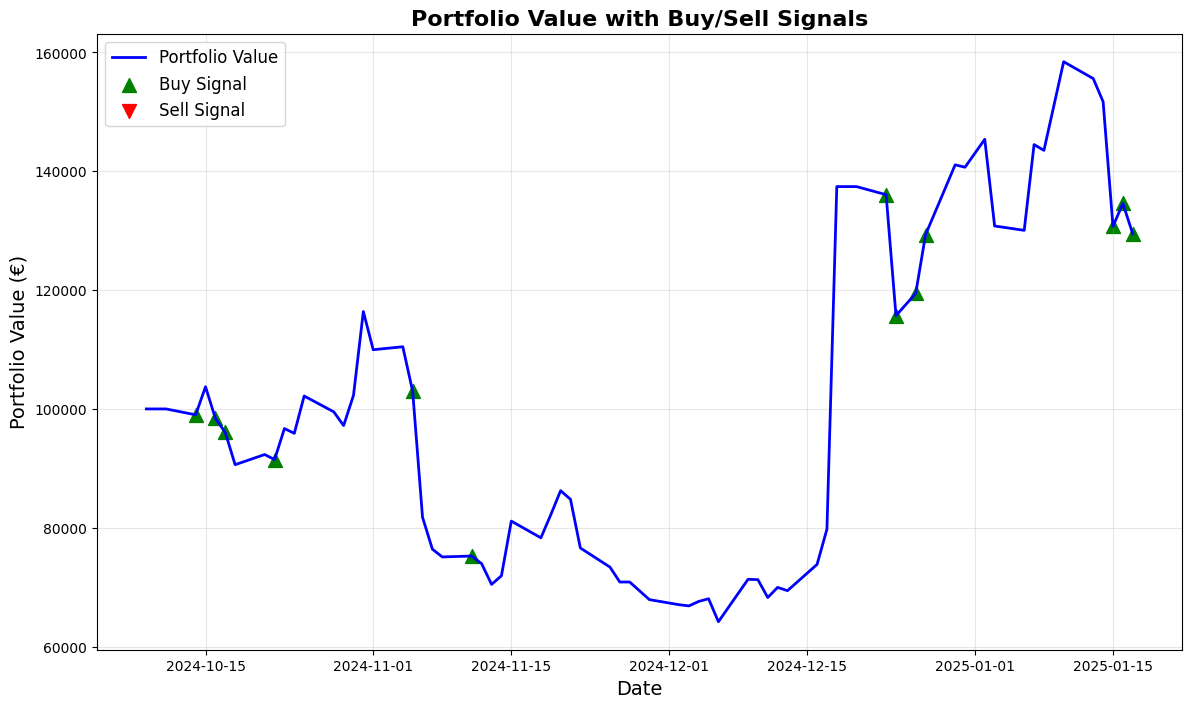

In [90]:
import matplotlib.pyplot as plt

def plot_backtesting_results(dataset):
    """
    Plots the backtesting results, including portfolio value and buy/sell signals.

    Parameters:
        - dataset: The DataFrame returned by `backtest_strategy` containing portfolio values and signals.

    Returns:
        - None
    """
    if dataset is None or dataset.empty:
        print("No data available to plot.")
        return

    # Extract buy and sell signals
    buy_signals = dataset[dataset['Strategy'] == 'Buy']
    sell_signals = dataset[dataset['Strategy'] == 'Sell']

    # Create the plot
    plt.figure(figsize=(14, 8))
    plt.plot(dataset.index, dataset['Portfolio_Value'], label='Portfolio Value', color='blue', linewidth=2)
    plt.scatter(buy_signals.index, buy_signals['Portfolio_Value'], color='green', label='Buy Signal', marker='^', s=100)
    plt.scatter(sell_signals.index, sell_signals['Portfolio_Value'], color='red', label='Sell Signal', marker='v', s=100)

    # Add titles and labels
    plt.title("Portfolio Value with Buy/Sell Signals", fontsize=16, fontweight='bold')
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Portfolio Value (€)", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)

    # Display the plot
    plt.show()


dataset = backtest_strategy(model)  
if dataset is not None:
    plot_backtesting_results(dataset)  
else:
    print("No dataset returned by backtest_strategy.")


# Chatbot

In [94]:
app = Flask(__name__)

# Chat endpoint to handle user messages with detailed explanations
@app.route('/chat', methods=['POST'])
def chat():
    user_message = request.json.get('message', '').strip().lower()
    response = ""

    # Fetch the dataset from backtest_strategy
    dataset = backtest_strategy(model)

    if dataset is None or dataset.empty:
        response = "Real-time data is unavailable at the moment. Please try again later."
        return jsonify({'response': response})

    # Get the latest row of the dataset
    latest_row = dataset.iloc[-1].to_dict()

    # Extract relevant data for explanation
    strategy = latest_row.get('Strategy', 'No Data')
    portfolio_value = latest_row.get('Portfolio_Value', 'Unavailable')
    current_price = latest_row.get('price', 'Unavailable')
    anomaly_prob = latest_row.get('Anomaly_Probability', 'Unavailable')
    moving_avg = latest_row.get('VIX_moving_average', 'Unavailable')

    # Define thresholds for explanation
    volatility_factor = 0.5  
    upper_threshold = moving_avg + volatility_factor if moving_avg != 'Unavailable' else 'Unavailable'
    lower_threshold = moving_avg - volatility_factor if moving_avg != 'Unavailable' else 'Unavailable'

    # Respond to user queries based on the strategy and explain the rationale
    if "buy" in user_message:
        if strategy == "Buy":
            response = (
                f"The strategy recommends buying. The current price is {current_price:.2f}, "
                f"which is below the lower threshold of {lower_threshold:.2f}. The anomaly probability is {anomaly_prob:.2f}, "
                f"indicating a potential upward trend. The portfolio value is currently {portfolio_value:.2f}."
            )
        else:
            response = (
                f"The strategy does not recommend buying at the moment. The current price is {current_price:.2f}, "
                f"which is within or above the expected range (between {lower_threshold:.2f} and {upper_threshold:.2f}). "
                f"The anomaly probability is {anomaly_prob:.2f}, suggesting no strong buy signals currently."
            )
    elif "sell" in user_message:
        if strategy == "Sell":
            response = (
                f"The strategy recommends selling. The current price is {current_price:.2f}, "
                f"which is above the upper threshold of {upper_threshold:.2f}. The anomaly probability is {anomaly_prob:.2f}, "
                f"indicating a potential downward trend. The portfolio value is currently {portfolio_value:.2f}."
            )
        else:
            response = (
                f"The strategy does not recommend selling at the moment. The current price is {current_price:.2f}, "
                f"which is within or below the expected range (between {lower_threshold:.2f} and {upper_threshold:.2f}). "
                f"The anomaly probability is {anomaly_prob:.2f}, suggesting no strong sell signals currently."
            )
    elif "strategy" in user_message or "current" in user_message:
        response = (
            f"The current strategy is: {strategy}. The current price is {current_price:.2f}, "
            f"the anomaly probability is {anomaly_prob:.2f}, and the portfolio value is {portfolio_value:.2f}. "
            f"The price is compared to the moving average of {moving_avg:.2f} with thresholds set at "
            f"{lower_threshold:.2f} (lower) and {upper_threshold:.2f} (upper)."
        )
    else:
        response = (
            "I did not understand your query. You can ask questions like 'Should I buy?', "
            "'Should I sell?', or 'What is the current strategy?'."
        )

    return jsonify({'response': response})

# Graph endpoint to generate portfolio value graph
@app.route('/graph', methods=['GET'])
def generate_graph():
    # Fetch the dataset from backtest_strategy
    dataset = backtest_strategy(model)

    if dataset is None or dataset.empty:
        return "Graph generation failed due to missing or empty data."

    # Plot the portfolio value
    plt.figure(figsize=(10, 6))
    plt.plot(dataset.index, dataset['Portfolio_Value'], label="Portfolio Value", color="#007bff", linewidth=2)
    plt.title("Portfolio Value Over Time", fontsize=16, fontweight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Value (€)", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    file_path = 'static/portfolio_graph.png'
    plt.savefig(file_path)
    plt.close()

    return send_file(file_path, mimetype='image/png')

# Main HTML interface for the chatbot
@app.route('/')
def index():
    return '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Investment Strategy Chatbot</title>
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0-alpha1/dist/css/bootstrap.min.css" rel="stylesheet">
    <style>
        body {
            background-color: #f5f6fa;
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
        }
        .chat-container {
            max-width: 700px;
            margin: 50px auto;
            padding: 20px;
            background: #ffffff;
            border-radius: 15px;
            box-shadow: 0 4px 10px rgba(0, 0, 0, 0.1);
            display: flex;
            flex-direction: column;
            height: 80vh;
        }
        #chat-box {
            flex-grow: 1;
            overflow-y: auto;
            padding: 15px;
            margin-bottom: 20px;
            border: 1px solid #ddd;
            border-radius: 10px;
            background-color: #f9f9f9;
        }
        .message {
            margin: 10px 0;
            display: flex;
            align-items: flex-end;
        }
        .bot-message {
            background: #e9f5e9;
            padding: 10px 15px;
            border-radius: 15px;
            max-width: 75%;
            box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);
        }
        .user-message {
            background: #d9f1ff;
            padding: 10px 15px;
            border-radius: 15px;
            max-width: 75%;
            margin-left: auto;
            box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);
        }
        .input-group {
            display: flex;
        }
        #message {
            flex-grow: 1;
            border-radius: 15px;
            padding: 10px;
            border: 1px solid #ced4da;
        }
        .btn {
            border-radius: 15px;
            margin-left: 10px;
        }
        h1 {
            color: #007bff;
        }
    </style>
</head>
<body>
    <div class="chat-container">
        <h1 class="text-center">Investment Strategy Chatbot</h1>
        <div id="chat-box"></div>
        <div class="input-group">
            <input type="text" id="message" class="form-control" placeholder="Ask about buying, selling, or the strategy...">
            <button class="btn btn-primary" onclick="sendMessage()">Send</button>
        </div>
    </div>

    <script>
        async function sendMessage() {
            const userMessage = document.getElementById("message").value.trim();
            if (!userMessage) {
                alert("Please enter a message.");
                return;
            }

            const chatBox = document.getElementById("chat-box");

            // Add user message
            chatBox.innerHTML += `<div class="message user-message">${userMessage}</div>`;
            chatBox.scrollTop = chatBox.scrollHeight;

            // Clear input field
            document.getElementById("message").value = "";

            // Fetch bot response
            const response = await fetch("/chat", {
                method: "POST",
                headers: { "Content-Type": "application/json" },
                body: JSON.stringify({ message: userMessage })
            });
            const data = await response.json();

            // Add bot response
            chatBox.innerHTML += `<div class="message bot-message">${data.response}</div>`;
            chatBox.scrollTop = chatBox.scrollHeight;
        }
    </script>
</body>
</html>
    '''

# Start Flask app
def run_flask():
    app.run(debug=True, port=5000, use_reloader=False)

if __name__ == '__main__':
    flask_thread = Thread(target=run_flask)
    flask_thread.start()


 * Serving Flask app '__main__'
 * Debug mode: on


Address already in use
Port 5000 is in use by another program. Either identify and stop that program, or start the server with a different port.
